In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml
import igraph
from collections import Counter
import networkx as nx

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 
from helpers.infodynamics import kld

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

def get_kld_ts(edges,topic_label):    
    tr = edges[edges.source == topic_label].groupby(['target','date']).mean().reset_index()
    tr = tr.pivot(index='date',columns='target',values='weight').fillna(0.0000000000000001)
    tr = tr.div(tr.sum(axis=1), axis=0)
    timestamps = tr.index.tolist()
    window = 4
    nsignal = np.zeros(len(tr))
    for i, x in enumerate(tr.to_numpy()):
        submat = tr.to_numpy()[(i - window):i,]
        tmp = np.zeros(submat.shape[0])
        if submat.any():
            for ii, xx in enumerate(submat):
                tmp[ii] = kld(x, xx)
        else:
            tmp = np.zeros([window])
        
        nsignal[i] = np.mean(tmp)
    return pd.DataFrame(nsignal,index=timestamps,columns=['kld'])

In [2]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')   
keys = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')
labels = dict(zip(keys.index,keys.label))
labels_reverse =dict(zip(labels.values(),labels.keys()))

In [3]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)
dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}
timestamps = sorted(list(set(dists.keys())))
del data

In [4]:
timeseries = []
edges = []

for c,date in tqdm(enumerate(dists)):
    theta = dists[date]
    prominence = {labels[c]:i for c,i in enumerate(theta.mean(axis=0))}

    theta = mutual_information(theta, topn=5)[0]
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=theta,weight_threshold=0,node_text='labels',labels=labels)
    edge_df['date'] = date
    edges.append(edge_df)
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    timeseries += [{"top":l,"date":date,"btw":btw[l],"deg":deg[l],"prom":prominence[l]} for l in btw.keys()]

timeseries = pd.DataFrame(timeseries)
edges = pd.concat(edges)

171it [02:04,  1.37it/s]


In [5]:
for col in ['btw','deg']:
    timeseries[col+'_rank'] = timeseries.groupby("date")[col].rank(method="dense", ascending=True)

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests

In [7]:
subtracted = {}
gcs = []

for top, dat in tqdm(timeseries.groupby('top')):

    dat = dat[['date','btw_rank','deg_rank','prom']]\
    .set_index('date')\
    .apply(zscore)\
    .rolling(10,center=True).mean()

    dat = dat[['prom','deg_rank']].pct_change().dropna()
    gc_res = grangercausalitytests(dat,8)
    gc_res = np.mean([v[0]['ssr_ftest'][1] for k,v in gc_res.items()])
    gcs.append({"topic":top,"gc":gc_res})

  2%|▏         | 4/186 [00:00<00:05, 35.85it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0530  , p=0.8184  , df_denom=100, df_num=1
ssr based chi2 test:   chi2=0.0546  , p=0.8153  , df=1
likelihood ratio test: chi2=0.0546  , p=0.8153  , df=1
parameter F test:         F=0.0530  , p=0.8184  , df_denom=100, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0461  , p=0.9549  , df_denom=97, df_num=2
ssr based chi2 test:   chi2=0.0970  , p=0.9526  , df=2
likelihood ratio test: chi2=0.0970  , p=0.9527  , df=2
parameter F test:         F=0.0461  , p=0.9549  , df_denom=97, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0322  , p=0.9922  , df_denom=94, df_num=3
ssr based chi2 test:   chi2=0.1039  , p=0.9914  , df=3
likelihood ratio test: chi2=0.1038  , p=0.9914  , df=3
parameter F test:         F=0.0322  , p=0.9922  , df_denom=94, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9293  , p=0.4506  , df

  6%|▋         | 12/186 [00:00<00:04, 38.35it/s]

likelihood ratio test: chi2=1.3321  , p=0.9952  , df=8
parameter F test:         F=0.1458  , p=0.9967  , df_denom=115, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0412  , p=0.8394  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0423  , p=0.8371  , df=1
likelihood ratio test: chi2=0.0422  , p=0.8372  , df=1
parameter F test:         F=0.0412  , p=0.8394  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0465  , p=0.9546  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.0970  , p=0.9527  , df=2
likelihood ratio test: chi2=0.0969  , p=0.9527  , df=2
parameter F test:         F=0.0465  , p=0.9546  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0507  , p=0.9848  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=0.1613  , p=0.9836  , df=3
likelihood ratio test: chi2=0.1612  , p=0.9836  , df=3
parameter F test:         F=0.0507  , p

 12%|█▏        | 22/186 [00:00<00:03, 41.06it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0959  , p=0.7573  , df_denom=157, df_num=1
ssr based chi2 test:   chi2=0.0977  , p=0.7546  , df=1
likelihood ratio test: chi2=0.0977  , p=0.7547  , df=1
parameter F test:         F=0.0959  , p=0.7573  , df_denom=157, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.9058 , p=0.0000  , df_denom=154, df_num=2
ssr based chi2 test:   chi2=24.5848 , p=0.0000  , df=2
likelihood ratio test: chi2=22.8598 , p=0.0000  , df=2
parameter F test:         F=11.9058 , p=0.0000  , df_denom=154, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.2618 , p=0.0000  , df_denom=151, df_num=3
ssr based chi2 test:   chi2=35.3517 , p=0.0000  , df=3
likelihood ratio test: chi2=31.9027 , p=0.0000  , df=3
parameter F test:         F=11.2618 , p=0.0000  , df_denom=151, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.8235  , p=0.0000  

 17%|█▋        | 32/186 [00:00<00:03, 43.10it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9697  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9694  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9694  , df=1
parameter F test:         F=0.0014  , p=0.9697  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0076  , p=0.9925  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=0.0156  , p=0.9922  , df=2
likelihood ratio test: chi2=0.0156  , p=0.9922  , df=2
parameter F test:         F=0.0076  , p=0.9925  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0569  , p=0.9821  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=0.1785  , p=0.9810  , df=3
likelihood ratio test: chi2=0.1784  , p=0.9810  , df=3
parameter F test:         F=0.0569  , p=0.9821  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0548  , p=0.9944  

 23%|██▎       | 42/186 [00:00<00:03, 44.19it/s]

ssr based F test:         F=0.0501  , p=0.8232  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=0.0511  , p=0.8211  , df=1
likelihood ratio test: chi2=0.0511  , p=0.8212  , df=1
parameter F test:         F=0.0501  , p=0.8232  , df_denom=148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0431  , p=0.9578  , df_denom=145, df_num=2
ssr based chi2 test:   chi2=0.0893  , p=0.9564  , df=2
likelihood ratio test: chi2=0.0892  , p=0.9564  , df=2
parameter F test:         F=0.0431  , p=0.9578  , df_denom=145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0794  , p=0.9711  , df_denom=142, df_num=3
ssr based chi2 test:   chi2=0.2500  , p=0.9691  , df=3
likelihood ratio test: chi2=0.2498  , p=0.9692  , df=3
parameter F test:         F=0.0794  , p=0.9711  , df_denom=142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1985  , p=0.9388  , df_denom=139, df_num=4
ssr based chi2 test: 

 28%|██▊       | 52/186 [00:01<00:02, 44.80it/s]

ssr based F test:         F=0.1907  , p=0.9026  , df_denom=138, df_num=3
ssr based chi2 test:   chi2=0.6010  , p=0.8962  , df=3
likelihood ratio test: chi2=0.5998  , p=0.8965  , df=3
parameter F test:         F=0.1907  , p=0.9026  , df_denom=138, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2416  , p=0.9143  , df_denom=135, df_num=4
ssr based chi2 test:   chi2=1.0307  , p=0.9051  , df=4
likelihood ratio test: chi2=1.0270  , p=0.9057  , df=4
parameter F test:         F=0.2416  , p=0.9143  , df_denom=135, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2745  , p=0.9264  , df_denom=132, df_num=5
ssr based chi2 test:   chi2=1.4867  , p=0.9146  , df=5
likelihood ratio test: chi2=1.4790  , p=0.9155  , df=5
parameter F test:         F=0.2745  , p=0.9264  , df_denom=132, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.2233  , p=0.9686  , df_denom=129, df_num=6
ssr based chi2 test: 

 31%|███       | 57/186 [00:01<00:02, 44.79it/s]

ssr based F test:         F=0.4075  , p=0.8429  , df_denom=124, df_num=5
ssr based chi2 test:   chi2=2.2182  , p=0.8182  , df=5
likelihood ratio test: chi2=2.2002  , p=0.8208  , df=5
parameter F test:         F=0.4075  , p=0.8429  , df_denom=124, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3572  , p=0.9045  , df_denom=121, df_num=6
ssr based chi2 test:   chi2=2.3736  , p=0.8823  , df=6
likelihood ratio test: chi2=2.3528  , p=0.8846  , df=6
parameter F test:         F=0.3572  , p=0.9045  , df_denom=121, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3069  , p=0.9496  , df_denom=118, df_num=7
ssr based chi2 test:   chi2=2.4217  , p=0.9329  , df=7
likelihood ratio test: chi2=2.3999  , p=0.9344  , df=7
parameter F test:         F=0.3069  , p=0.9496  , df_denom=118, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.2667  , p=0.9754  , df_denom=115, df_num=8
ssr based chi2 test: 

 36%|███▌      | 67/186 [00:01<00:02, 45.63it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.3951 , p=0.0000  , df_denom=157, df_num=1
ssr based chi2 test:   chi2=21.8040 , p=0.0000  , df=1
likelihood ratio test: chi2=20.4408 , p=0.0000  , df=1
parameter F test:         F=21.3951 , p=0.0000  , df_denom=157, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.7214 , p=0.0000  , df_denom=154, df_num=2
ssr based chi2 test:   chi2=22.1390 , p=0.0000  , df=2
likelihood ratio test: chi2=20.7273 , p=0.0000  , df=2
parameter F test:         F=10.7214 , p=0.0000  , df_denom=154, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.0374  , p=0.0002  , df_denom=151, df_num=3
ssr based chi2 test:   chi2=22.0909 , p=0.0001  , df=3
likelihood ratio test: chi2=20.6770 , p=0.0001  , df=3
parameter F test:         F=7.0374  , p=0.0002  , df_denom=151, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1726  , p=0.0006  

 41%|████▏     | 77/186 [00:01<00:02, 44.08it/s]

parameter F test:         F=0.0274  , p=1.0000  , df_denom=138, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0254  , p=1.0000  , df_denom=135, df_num=8
ssr based chi2 test:   chi2=0.2287  , p=1.0000  , df=8
likelihood ratio test: chi2=0.2285  , p=1.0000  , df=8
parameter F test:         F=0.0254  , p=1.0000  , df_denom=135, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0231  , p=0.8795  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.0235  , p=0.8781  , df=1
likelihood ratio test: chi2=0.0235  , p=0.8781  , df=1
parameter F test:         F=0.0231  , p=0.8795  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0111  , p=0.9890  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.0229  , p=0.9886  , df=2
likelihood ratio test: chi2=0.0229  , p=0.9886  , df=2
parameter F test:         F=0.0111  , p=0.9890  , df_denom=146, df_num=2

Granger Causality
nu

 47%|████▋     | 87/186 [00:02<00:02, 44.26it/s]

ssr based F test:         F=5.2373  , p=0.0000  , df_denom=80, df_num=8
ssr based chi2 test:   chi2=50.8021 , p=0.0000  , df=8
likelihood ratio test: chi2=40.8529 , p=0.0000  , df=8
parameter F test:         F=5.2373  , p=0.0000  , df_denom=80, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9208  , df_denom=126, df_num=1
ssr based chi2 test:   chi2=0.0102  , p=0.9197  , df=1
likelihood ratio test: chi2=0.0102  , p=0.9197  , df=1
parameter F test:         F=0.0099  , p=0.9208  , df_denom=126, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9722  , p=0.3812  , df_denom=123, df_num=2
ssr based chi2 test:   chi2=2.0233  , p=0.3636  , df=2
likelihood ratio test: chi2=2.0075  , p=0.3665  , df=2
parameter F test:         F=0.9722  , p=0.3812  , df_denom=123, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9735  , p=0.4077  , df_denom=120, df_num=3
ssr based chi2 test:   

 52%|█████▏    | 97/186 [00:02<00:01, 45.05it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9749  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9746  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9746  , df=1
parameter F test:         F=0.0010  , p=0.9749  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0006  , p=0.9994  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=0.0011  , p=0.9994  , df=2
likelihood ratio test: chi2=0.0011  , p=0.9994  , df=2
parameter F test:         F=0.0006  , p=0.9994  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0064  , p=0.9993  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=0.0199  , p=0.9993  , df=3
likelihood ratio test: chi2=0.0199  , p=0.9993  , df=3
parameter F test:         F=0.0064  , p=0.9993  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0071  , p=0.9999  

 58%|█████▊    | 107/186 [00:02<00:01, 45.85it/s]

ssr based F test:         F=0.0121  , p=0.9982  , df_denom=149, df_num=3
ssr based chi2 test:   chi2=0.0381  , p=0.9980  , df=3
likelihood ratio test: chi2=0.0381  , p=0.9980  , df=3
parameter F test:         F=0.0121  , p=0.9982  , df_denom=149, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0221  , p=0.9990  , df_denom=146, df_num=4
ssr based chi2 test:   chi2=0.0940  , p=0.9989  , df=4
likelihood ratio test: chi2=0.0940  , p=0.9989  , df=4
parameter F test:         F=0.0221  , p=0.9990  , df_denom=146, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.0203  , p=0.9998  , df_denom=143, df_num=5
ssr based chi2 test:   chi2=0.1092  , p=0.9998  , df=5
likelihood ratio test: chi2=0.1092  , p=0.9998  , df=5
parameter F test:         F=0.0203  , p=0.9998  , df_denom=143, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.0167  , p=1.0000  , df_denom=140, df_num=6
ssr based chi2 test: 

 63%|██████▎   | 117/186 [00:02<00:01, 46.50it/s]

parameter F test:         F=0.0015  , p=1.0000  , df_denom=143, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0034  , p=1.0000  , df_denom=140, df_num=8
ssr based chi2 test:   chi2=0.0306  , p=1.0000  , df=8
likelihood ratio test: chi2=0.0306  , p=1.0000  , df=8
parameter F test:         F=0.0034  , p=1.0000  , df_denom=140, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0404  , p=0.8410  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.0411  , p=0.8393  , df=1
likelihood ratio test: chi2=0.0411  , p=0.8393  , df=1
parameter F test:         F=0.0404  , p=0.8410  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0463  , p=0.9547  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=0.0956  , p=0.9533  , df=2
likelihood ratio test: chi2=0.0956  , p=0.9533  , df=2
parameter F test:         F=0.0463  , p=0.9547  , df_denom=158, df_num=2

Granger Causality
nu

 66%|██████▌   | 122/186 [00:02<00:01, 46.38it/s]

ssr based F test:         F=0.2702  , p=0.7636  , df_denom=150, df_num=2
ssr based chi2 test:   chi2=0.5584  , p=0.7564  , df=2
likelihood ratio test: chi2=0.5574  , p=0.7568  , df=2
parameter F test:         F=0.2702  , p=0.7636  , df_denom=150, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7549  , p=0.5212  , df_denom=147, df_num=3
ssr based chi2 test:   chi2=2.3725  , p=0.4988  , df=3
likelihood ratio test: chi2=2.3545  , p=0.5022  , df=3
parameter F test:         F=0.7549  , p=0.5212  , df_denom=147, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0718  , p=0.3728  , df_denom=144, df_num=4
ssr based chi2 test:   chi2=4.5549  , p=0.3361  , df=4
likelihood ratio test: chi2=4.4885  , p=0.3439  , df=4
parameter F test:         F=1.0718  , p=0.3728  , df_denom=144, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8444  , p=0.5204  , df_denom=141, df_num=5
ssr based chi2 test: 

 71%|███████   | 132/186 [00:02<00:01, 46.42it/s]

ssr based F test:         F=0.0892  , p=0.9973  , df_denom=127, df_num=6
ssr based chi2 test:   chi2=0.5899  , p=0.9966  , df=6
likelihood ratio test: chi2=0.5886  , p=0.9966  , df=6
parameter F test:         F=0.0892  , p=0.9973  , df_denom=127, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.0815  , p=0.9991  , df_denom=124, df_num=7
ssr based chi2 test:   chi2=0.6396  , p=0.9988  , df=7
likelihood ratio test: chi2=0.6381  , p=0.9988  , df=7
parameter F test:         F=0.0815  , p=0.9991  , df_denom=124, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0730  , p=0.9997  , df_denom=121, df_num=8
ssr based chi2 test:   chi2=0.6665  , p=0.9996  , df=8
likelihood ratio test: chi2=0.6649  , p=0.9996  , df=8
parameter F test:         F=0.0730  , p=0.9997  , df_denom=121, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0045  , p=0.9468  , df_denom=137, df_num=1
ssr based chi2 test: 

 76%|███████▋  | 142/186 [00:03<00:00, 45.24it/s]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5043  , p=0.0630  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=3.5696  , p=0.0588  , df=1
likelihood ratio test: chi2=3.5313  , p=0.0602  , df=1
parameter F test:         F=3.5043  , p=0.0630  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0367  , p=0.1339  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=4.2023  , p=0.1223  , df=2
likelihood ratio test: chi2=4.1490  , p=0.1256  , df=2
parameter F test:         F=2.0367  , p=0.1339  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4914  , p=0.2191  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=4.6762  , p=0.1971  , df=3
likelihood ratio test: chi2=4.6100  , p=0.2027  , df=3
parameter F test:         F=1.4914  , p=0.2191  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3881  , p=0.2407  

 82%|████████▏ | 152/186 [00:03<00:00, 44.37it/s]

parameter F test:         F=1.9057  , p=0.0728  , df_denom=143, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6975  , p=0.1040  , df_denom=140, df_num=8
ssr based chi2 test:   chi2=15.2286 , p=0.0548  , df=8
likelihood ratio test: chi2=14.5346 , p=0.0689  , df=8
parameter F test:         F=1.6975  , p=0.1040  , df_denom=140, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9850  , df_denom=157, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9848  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9848  , df=1
parameter F test:         F=0.0004  , p=0.9850  , df_denom=157, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0024  , p=0.9976  , df_denom=154, df_num=2
ssr based chi2 test:   chi2=0.0049  , p=0.9975  , df=2
likelihood ratio test: chi2=0.0049  , p=0.9975  , df=2
parameter F test:         F=0.0024  , p=0.9976  , df_denom=154, df_num=2

Granger Causality
nu

 87%|████████▋ | 162/186 [00:03<00:00, 44.85it/s]

ssr based F test:         F=2.5456  , p=0.0169  , df_denom=141, df_num=7
ssr based chi2 test:   chi2=19.7147 , p=0.0062  , df=7
likelihood ratio test: chi2=18.5649 , p=0.0097  , df=7
parameter F test:         F=2.5456  , p=0.0169  , df_denom=141, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8479  , p=0.0059  , df_denom=138, df_num=8
ssr based chi2 test:   chi2=25.5898 , p=0.0012  , df=8
likelihood ratio test: chi2=23.6845 , p=0.0026  , df=8
parameter F test:         F=2.8479  , p=0.0059  , df_denom=138, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3264  , p=0.5686  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.3325  , p=0.5642  , df=1
likelihood ratio test: chi2=0.3321  , p=0.5644  , df=1
parameter F test:         F=0.3264  , p=0.5686  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1655  , p=0.8476  , df_denom=158, df_num=2
ssr based chi2 test: 

 92%|█████████▏| 172/186 [00:03<00:00, 45.83it/s]

parameter F test:         F=0.0558  , p=0.9999  , df_denom=89, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0911  , p=0.7632  , df_denom=150, df_num=1
ssr based chi2 test:   chi2=0.0929  , p=0.7605  , df=1
likelihood ratio test: chi2=0.0929  , p=0.7605  , df=1
parameter F test:         F=0.0911  , p=0.7632  , df_denom=150, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0522  , p=0.9491  , df_denom=147, df_num=2
ssr based chi2 test:   chi2=0.1080  , p=0.9474  , df=2
likelihood ratio test: chi2=0.1080  , p=0.9474  , df=2
parameter F test:         F=0.0522  , p=0.9491  , df_denom=147, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3166  , p=0.8133  , df_denom=144, df_num=3
ssr based chi2 test:   chi2=0.9961  , p=0.8022  , df=3
likelihood ratio test: chi2=0.9928  , p=0.8030  , df=3
parameter F test:         F=0.3166  , p=0.8133  , df_denom=144, df_num=3

Granger Causality
num

 98%|█████████▊| 182/186 [00:04<00:00, 46.24it/s]

parameter F test:         F=0.3508  , p=0.8430  , df_denom=119, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2416  , p=0.0547  , df_denom=116, df_num=5
ssr based chi2 test:   chi2=12.2709 , p=0.0313  , df=5
likelihood ratio test: chi2=11.7137 , p=0.0389  , df=5
parameter F test:         F=2.2416  , p=0.0547  , df_denom=116, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8434  , p=0.0969  , df_denom=113, df_num=6
ssr based chi2 test:   chi2=12.3326 , p=0.0549  , df=6
likelihood ratio test: chi2=11.7657 , p=0.0674  , df=6
parameter F test:         F=1.8434  , p=0.0969  , df_denom=113, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5964  , p=0.1439  , df_denom=110, df_num=7
ssr based chi2 test:   chi2=12.6984 , p=0.0798  , df=7
likelihood ratio test: chi2=12.0940 , p=0.0975  , df=7
parameter F test:         F=1.5964  , p=0.1439  , df_denom=110, df_num=7

Granger Causality
nu

100%|██████████| 186/186 [00:04<00:00, 44.61it/s]

ssr based F test:         F=0.9817  , p=0.3233  , df_denom=154, df_num=1
ssr based chi2 test:   chi2=1.0008  , p=0.3171  , df=1
likelihood ratio test: chi2=0.9976  , p=0.3179  , df=1
parameter F test:         F=0.9817  , p=0.3233  , df_denom=154, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4466  , p=0.6406  , df_denom=151, df_num=2
ssr based chi2 test:   chi2=0.9228  , p=0.6304  , df=2
likelihood ratio test: chi2=0.9200  , p=0.6313  , df=2
parameter F test:         F=0.4466  , p=0.6406  , df_denom=151, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3027  , p=0.8234  , df_denom=148, df_num=3
ssr based chi2 test:   chi2=0.9509  , p=0.8131  , df=3
likelihood ratio test: chi2=0.9480  , p=0.8138  , df=3
parameter F test:         F=0.3027  , p=0.8234  , df_denom=148, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6131  , p=0.1741  , df_denom=145, df_num=4
ssr based chi2 test: 

In [8]:
gdf = pd.DataFrame(gcs)
gdf['gcr'] = gdf.gc.round(1)

In [9]:
selection = gdf[gdf.gcr > .95].topic.tolist()

100%|██████████| 186/186 [00:14<00:00, 12.56it/s]


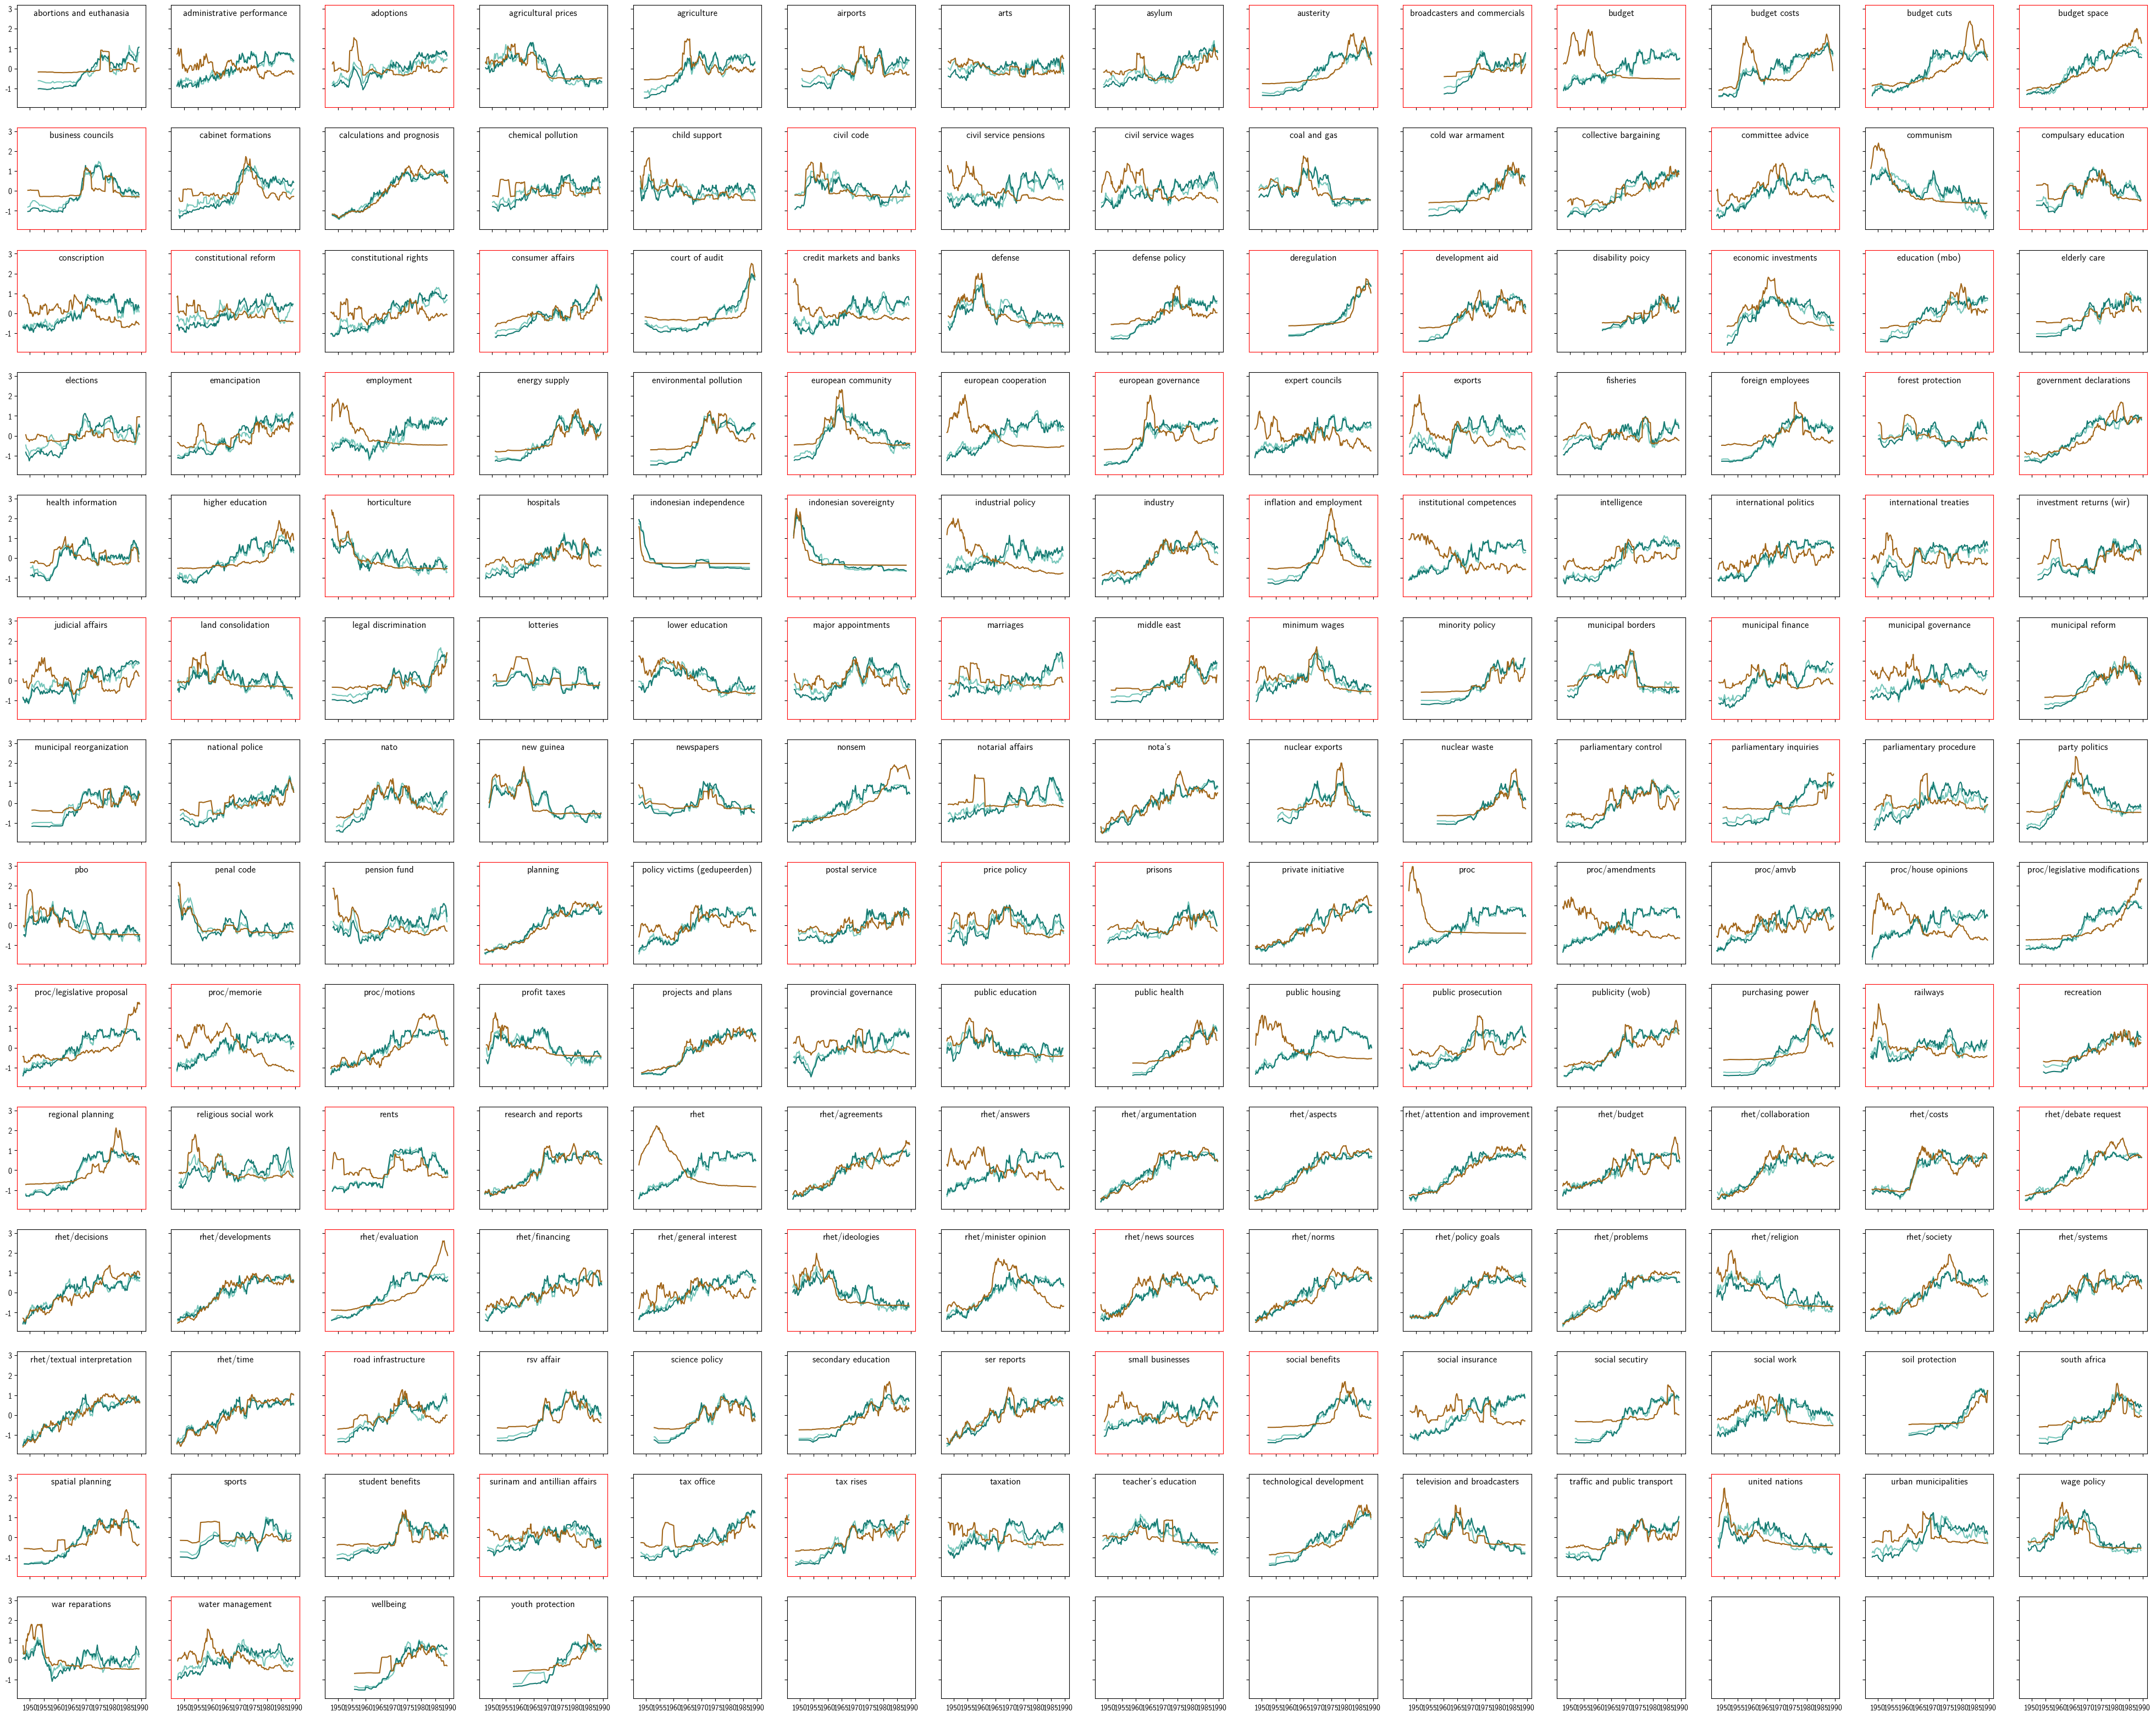

In [10]:
fig,ax = plt.subplots(14,14,figsize=(50,40),sharex=True,sharey=True)
pal = sns.color_palette('BrBG')
col = [pal[-2],pal[-1],pal[0]]

c = 0
for top, dat in tqdm(timeseries.groupby('top')):
    ax_ = ax.flatten()[c]
    dat = dat[['date','btw_rank','deg_rank','prom']]\
    .set_index('date')\
    .apply(zscore)\
    .rolling(10,center=True).mean()\

    for co,c_ in enumerate(['btw_rank','deg_rank','prom']):
        ax_.plot(dat.index.to_timestamp(),dat[c_],color=col[co])
    ax_.text(.5,.9,top,
        horizontalalignment='center',
        transform=ax_.transAxes)
    plt.setp(ax_.spines.values(), color='red' if top in selection else 'black')
    c += 1
plt.savefig('/home/rb/Desktop/all-topics.pdf')
plt.show()

In [178]:
m = 28
subtracted_l = subtracted.items()
Ts=[a for t,a in subtracted_l]
radius, Ts_idx, subseq_idx = stumpy.ostinato(Ts=[a for t,a in subtracted_l], m = m)

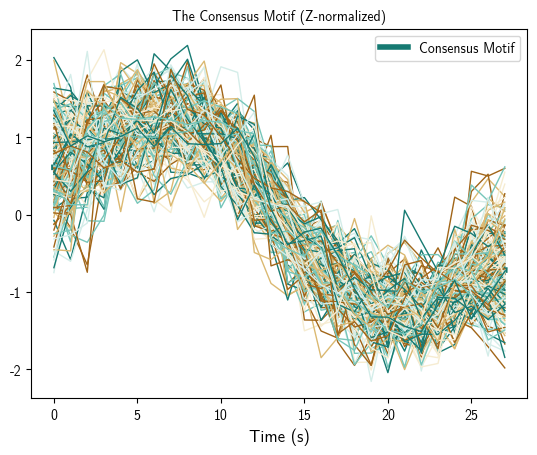

In [179]:
consensus_motif = Ts[Ts_idx][subseq_idx : subseq_idx + m]
nn_idx = []
for i, T in enumerate(Ts):
    nn_idx.append(np.argmin(stumpy.core.mass(consensus_motif, T)))
    lw = 1
    label = None
    if i == Ts_idx:
        lw = 4
        label = 'Consensus Motif'
    plt.plot(stumpy.core.z_norm(T[nn_idx[i] : nn_idx[i]+m]), lw=lw, label=label)

plt.title('The Consensus Motif (Z-normalized)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [176]:
from matplotlib.patches import Rectangle

def plot_vertical():
    fig, ax = plt.subplots(len(Ts), sharex=True, sharey=True,figsize=(4,100))
    colors = plt.rcParams["axes.prop_cycle"]()
    for i, T in enumerate(Ts):
        ax[i].plot(T, color='black')
    plt.subplots_adjust(hspace=0)
    plt.xlabel('Time')
    return ax

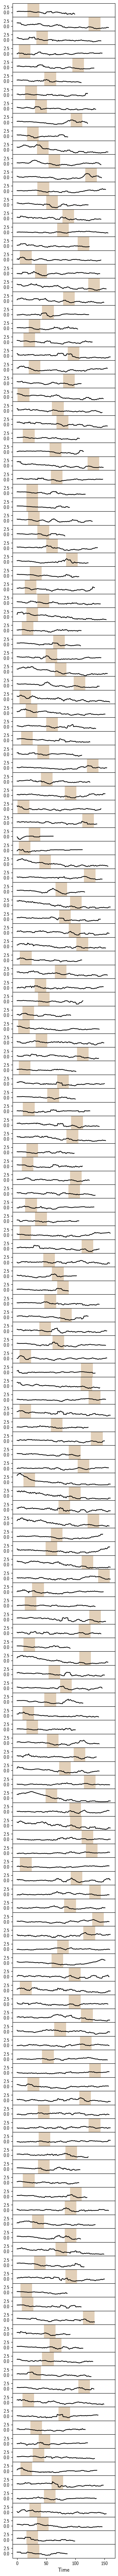

In [177]:
ax = plot_vertical()
ymin, ymax = ax[i].get_ylim()
for i in range(len(Ts)):
    r = Rectangle((nn_idx[i], ymin), m, ymax-ymin, alpha=0.3)
    ax[i].add_patch(r)
plt.show()


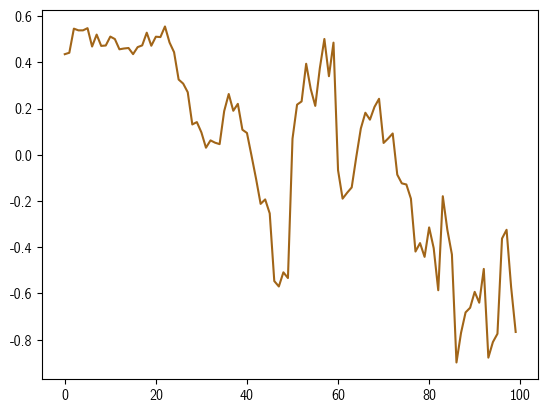

In [173]:
plt.plot(Ts[0])